In [2]:
import pandas as pd
df1=pd.read_csv("C:\\Users\\Hasan\\Downloads\\datasets_141926_333383_Youtube01-Psy.csv")
df2=pd.read_csv("C:\\Users\\Hasan\\Downloads\\datasets_141926_333383_Youtube02-KatyPerry.csv")
df3=pd.read_csv("C:\\Users\\Hasan\\Downloads\\datasets_141926_333383_Youtube03-LMFAO.csv")
df4=pd.read_csv("C:\\Users\\Hasan\\Downloads\\datasets_141926_333383_Youtube04-Eminem.csv")
df5=pd.read_csv("C:\\Users\\Hasan\\Downloads\\datasets_141926_333383_Youtube05-Shakira.csv")

In [ ]:
print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)
print(df5.shape)

In [3]:
df=pd.concat([df1,df2,df3,df4,df5],ignore_index=True) 
df.shape

(1956, 5)

In [88]:
df.CLASS.value_counts() #to check if dataset is balanced or not

1    1005
0     951
Name: CLASS, dtype: int64

In [93]:
df.isnull().sum()

CONTENT      0
CLASS        0
len          0
words        0
processed    0
dtype: int64

In [4]:
df.drop(['COMMENT_ID', 'AUTHOR', 'DATE'], inplace=True, axis=1)
df.columns

Index(['CONTENT', 'CLASS'], dtype='object')

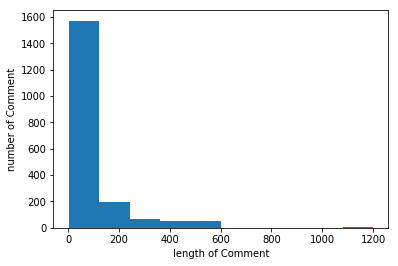

In [96]:
#Displaying the average length of spam and not-spam sentence

import matplotlib.pyplot as plt

df["len"]=[len(x) for x in df.CONTENT]
plt.hist(df.len)
plt.ylabel("number of Comment")
plt.xlabel("length of Comment")
plt.show()

In [94]:
df.len.mean() # finding average length of comment

94.70092024539878

so, the mean length of comment is 95 word.

In [98]:
a=df[df.len>100] 
a.CLASS.value_counts()

1    375
0    102
Name: CLASS, dtype: int64

Comment whose length greater than 100 are mostly spam comment.

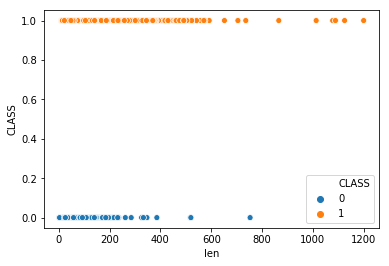

In [99]:
import seaborn as sns
sns.scatterplot(x=df.len,hue=df.CLASS,y=df.CLASS)

In [100]:
df.groupby(["CLASS"])["len"].mean() # finding average length of spam and not-spam sentence

CLASS
0     49.644585
1    137.336318
Name: len, dtype: float64

Above cell tells us that mean length of spam comment is quite greater than not spam-comment.

# Let's do some Text-preprocessing and Training

In [6]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import numpy as np 
import nltk
import re

df['words'] = [re.sub(r'\W+',' ', x) for x in df['CONTENT']] # Replacing all non alpha-nmeric character
df['words'] = [nltk.word_tokenize(x) for x in df["words"]]# tokenizing each sentence


In [7]:
stops = set(stopwords.words("english"))                  

def remove_stopword(row):
    my_list = row['words']
    meaningful_words = [w for w in my_list if not w in stops]
    return (meaningful_words)

df['words'] = df.apply(remove_stopword, axis=1)


In [8]:
df['text']=[ " ".join(i) for i in df['words']]


In [9]:
X = df['text']
y = df['CLASS']
print(X.shape)
print(y.shape)

(1956,)
(1956,)


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)

print(X_train.shape)
print(X_test.shape)

(1467,)
(489,)


In [11]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(ngram_range=(1,3))

X_train_dtm = vect.fit_transform(X_train)

X_test_dtm = vect.transform(X_test)

# Searching for the best model

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.metrics import f1_score


In [103]:
def best_model(x,y):
    models=[['Decision Tree classifier :',DecisionTreeClassifier()],
           ['Linear classifier :',LogisticRegression()],
           ['Random Forest classifier :',RandomForestClassifier()],
           ['SVM classifier :',svm.SVC(kernel='linear')],
           ['naive-bayes :', MultinomialNB()],
           ['AdaBoostClassifier : ', AdaBoostClassifier()]]

    print("Different Model accuracy")
    print("\n")
    for name,model in models:
        model=model
        model.fit(X_train_dtm,y_train)
        predictions = model.predict(X_test_dtm)
        acc=accuracy_score(y_test, predictions)
        score = f1_score(predictions, y_test)
        print("accuracy"+" of "+ name, acc)
        print("F1-score"+" of "+ name, score)
        print(confusion_matrix(y_test,predictions))
        
        print("\n")

Our dataset is balanced so we will focus on accuracy score for selecting best model, for imbalanced dataset we will depend more on Precesion, Recall and F1-score.

In [104]:
best_model(X_train_dtm,y_train)

Different Model accuracy


accuracy of Decision Tree classifier : 0.9406952965235174
F1-score of Decision Tree classifier : 0.9430255402750491
[[220   9]
 [ 20 240]]


accuracy of Linear classifier : 0.9222903885480572
F1-score of Linear classifier : 0.9224489795918367
[[225   4]
 [ 34 226]]


accuracy of Random Forest classifier : 0.9284253578732107
F1-score of Random Forest classifier : 0.9284253578732106
[[227   2]
 [ 33 227]]


accuracy of SVM classifier : 0.9366053169734151
F1-score of SVM classifier : 0.93812375249501
[[223   6]
 [ 25 235]]


accuracy of naive-bayes : 0.8957055214723927
F1-score of naive-bayes : 0.9050279329608939
[[195  34]
 [ 17 243]]


accuracy of AdaBoostClassifier :  0.9243353783231084
F1-score of AdaBoostClassifier :  0.9252525252525252
[[223   6]
 [ 31 229]]




Decision Tree classifier, SVM classifier and Random Forest classifier comes out to be the best model in this case. we will select  Random Forest classifier as our model because of Accuracy and FalsePositive(FP).Now lets find the best parameter of Random Forest classifier

# Hyper parameter tuning

In [87]:
from sklearn.model_selection import GridSearchCV, cross_val_score
classifier=RandomForestClassifier()
parameter={"n_estimators" : [2,5,10,20,50,100,200],
            "max_depth" : [10, 20, 50, 80, 100],
            "min_samples_leaf": [2, 4,8,12],
            "max_features" : ['auto', 'sqrt'],
            "min_samples_split" : [2, 5, 10,20,50]}
grid = GridSearchCV(classifier, param_grid=parameter, cv=5, scoring='accuracy')
grid.fit(X_train_dtm,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [2, 5, 10, 20, 50, 100, 200], 'max_depth': [10, 20, 50, 80, 100], 'min_samples_leaf': [2, 4, 8, 12], 'max_features': ['auto', 'sqrt'], 'min_samples_split': [2, 5, 10, 20, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [89]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.9277436946148603
{'max_depth': 80, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 100}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=80, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


# Now building the model with best parameter

In [102]:
classifier=RandomForestClassifier()
classifier.fit(X_train_dtm,y_train)
simple_test=["like for like and share for share"]
simple_test_dtm = vect.transform(simple_test)
classifier.predict(simple_test_dtm.toarray())

array([1], dtype=int64)

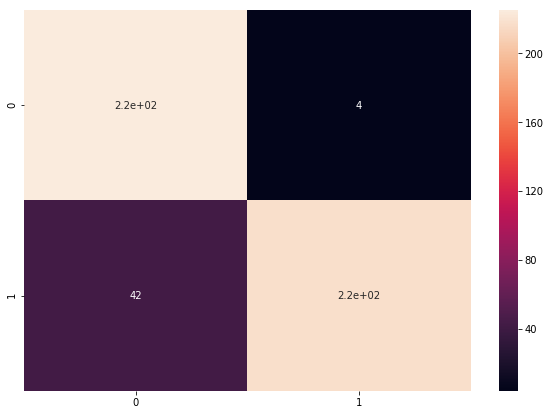

In [91]:
import matplotlib.pyplot as plt
y_predict=classifier.predict(X_test_dtm)
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_predict)
import seaborn as sn
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True)